In [1]:
GPU = True  #set to True to use GPU for XGboost 
OPTUNA = False #set to True to run Optuna first, false to use saved hyperparameters
MODEL_NAME = "xgboost"
#MODEL_NAME = "lightgbm"

## Model Testing

Runs Gradient-Boosted Tree (gbt) training models (option to select Xgboost or Lightgbm) and logs the key information to Neptune.ai. 

(Originally 2 notebooks were utilized, one for XGB and one for LGB, but these were converted to this single notebook for convenience. Simple "if" statements are used to select the small differences in code when choosing one or the other.)

If Optuna is set to True, then hyperparameters are tuned first and used for the test run. Otherwise, the current best hyperparameters are kept in a JSON file and are utilized instead. If Optuna is utilized, then a separate Neptune logging run is initialized to record the key tuning data.

Various metrics are calculated and recorded. AUC will likely be of primary interest since the eventual goal is to compare win-lose probabilities against betting odds, not necessarily to accurately predict the winner for each game. Accuracy is an interesting metric though, and is recorded as well.

Along with standard built-in measures for feature importance using weight and gain, Shapley value feature importances are also generated to give a different perspective on feature importances. These Shapley feature importances are local to the specific data run through the model and therefore can be used in some form of adversarial evaluation, such as train data vs test data and/or test split 1 vs test split 2 (see below.)

This model evaluation does include splitting the test set into "early" season data (Test1) and "later" season data (Test2) and comparing the performance on each.

Process flow:

- load data that has gone through feature engineering and selection
- initialize Neptune.ai logging run
- set key options
- fix datatypes for correct date format and decrease memory footprint
- perform any categorical encoding required for XGB or LGB
- drop any features that are not useful and set the target
- load hyperparameters from JSON file or re-tune them with Optuna
- train the model with stratified K-fold cross validation
- output key metrics and feature importances for Out-of-Fold validation set
- run the model on the test/validation set
- output key metrics and feature importances for test/validation data
- split the test/validation data into Test1 (early season) and Test2 (later season)
- run model on each
- output key metrics and feature importances for each
- perform model evaluation, comparing train vs test and test1 vs test2
- if re-tuned hyperparameters are better (per human inspection) then manually run the function to save these as new defaults. (These re-tuned hyperparameters are always logged at Neptune.ai and can be retrieved whenever necessary, but human interaction is required to establish new default parameters because various experiments might not be optimal in the long run.)



In [2]:
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import (
    StratifiedKFold, 
    TimeSeriesSplit,
)

from sklearn.calibration import (   
    calibration_curve,
    CalibratedClassifierCV,
)


import xgboost as xgb
from xgboost import XGBClassifier
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import (
    early_stopping,
    log_evaluation,
)
print('LGB version:', lgb.__version__)

import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances,
)

from src.optuna_objectives import (
    XGB_objective,
    LGB_objective,
)

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
from neptune.new.integrations.lightgbm import (
    NeptuneCallback as LGB_NeptuneCallback, 
    create_booster_summary,
)

import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

import joblib

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



import ipynbname

import json

from datetime import datetime

from src.data_processing import (
    process_games,
    add_TARGET,
    split_train_test,
)

from src.feature_engineering import (
    process_features,
    remove_non_rolling,
)

from src.common_functions import (
    plot_confusion_matrix,
    run_sweetviz_comparison,
)

from src.model_training import (
    fix_datatypes,
    encode_categoricals,
    plot_calibration_curve,
    calculate_classification_metrics
)


from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import warnings
warnings.simplefilter('ignore')




XGB version: 1.6.1
LGB version: 3.3.2


In [3]:

def update_training_data():
    
    # when this notebook is run from notebook 10_model_training.pipeline, it handles retrieving the most current data from Hopsworks.AI
    # this function here is used to update the training data when one wishes to use local data stored in games.csv instead of connecting to Hopsworks.AI
    # games.csv will need to be first updated itself if the most current data is desired
    # all the pre-processing steps are run again, and the train and test sets are saved to the data folder
    

    games = pd.read_csv(DATAPATH / "games.csv")
    games = process_games(games)
    games = add_TARGET(games)
    games = process_features(games)
    train, test = split_train_test(games)
    train.to_csv(DATAPATH / "train_selected.csv",index=False)
    test.to_csv(DATAPATH / "test_selected.csv",index=False)

#update_training_data()


In [4]:
TRAIN_NAME = "train_selected.csv"
TEST_NAME = "test_selected.csv"

train = pd.read_csv(DATAPATH / TRAIN_NAME)
test = pd.read_csv(DATAPATH / TEST_NAME)


**Setup Neptuna.ai experiment tracking**

In [5]:
LOGGING_NOTE = "pipeline test"

#from dotenv import load_dotenv

#load_dotenv()
try:

    NEPTUNE_API_TOKEN = os.environ['NEPTUNE_API_TOKEN']
except:
    raise Exception('Set environment variable NEPTUNE_API_TOKEN')
    
PROJECT = "cmunch1/nba-prediction"
PROJECT_OPTUNA = "cmunch1/nba-optuna" #for 2nd run if hyperparameters are tuned
SOURCE = "07_model_testing.ipynb"


run = neptune.init(
    project=PROJECT,
    source_files=[SOURCE],
    api_token=NEPTUNE_API_TOKEN,
)
if MODEL_NAME == "xgboost":
    neptune_callback = NeptuneCallback(run=run)
if MODEL_NAME == "lightgbm":
    neptune_callback = LGB_NeptuneCallback(run=run)

run["note"] = LOGGING_NOTE
run["sys/tags"].add([MODEL_NAME,])
run['dataset/train'] = TRAIN_NAME
run['dataset/test'] = TEST_NAME

https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-145
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Options**

In [6]:
run["model/parameters/GPU"] = GPU
run["model/parameters/OPTUNA"] = OPTUNA

#OPTUNA_CV = "TimeSeriesSplit"
OPTUNA_CV = "StratifiedKFold"  

if OPTUNA:
    run["model/optuna/optuna_cv"] = OPTUNA_CV
    run["model/optuna/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/optuna/optuna_trials"] = OPTUNA_TRIALS = 150

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 2000 #xgb param
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = False
run["model/parameters/early_stopping"] = EARLY_STOPPING = 200 

VERBOSITY = 0 #xgb param
LGB_VERBOSITY = -1 #lgb param
VERBOSE_EVAL = False #lgb param
LOG_EVALUATION = 10000 #lgb display parameter

#lgb train params
if MODEL_NAME == "lightgbm":
    CALLBACKS = [log_evaluation(LOG_EVALUATION),] # early_stopping(EARLY_STOPPING,verbose=False),]

if MODEL_NAME == "xgboost":

    BASE_MODEL = xgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'eval_metric': 'auc',
                    "objective": "binary:logistic",
                    'verbosity': VERBOSITY,
                    }

    GPU_PARAMS = {
                 'tree_method': 'gpu_hist',
                 'predictor': 'gpu_predictor',
                 }
    
if MODEL_NAME == "lightgbm":
    
    BASE_MODEL = lgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'verbosity': LGB_VERBOSITY,           
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc', 
                    }

    GPU_PARAMS = {
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0,
                 }


if GPU:
    STATIC_PARAMS = STATIC_PARAMS | GPU_PARAMS


**Fix Datatypes for smaller memory footprint**

In [7]:
date_fields = ['GAME_DATE_EST',]
long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']


train = fix_datatypes(train, date_fields, long_integer_fields)
test = fix_datatypes(test, date_fields, long_integer_fields)


**Encode categoricals**

In [8]:
category_columns = ['SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID' ]

train = encode_categoricals(train, category_columns, MODEL_NAME, ENABLE_CATEGORICAL)
test = encode_categoricals(test, category_columns, MODEL_NAME, ENABLE_CATEGORICAL)

**Drop Features**

In [9]:
target = train['TARGET']
test_target = test['TARGET']
test_target_original = test['TARGET'] #save for later probability calibration

all_columns = remove_non_rolling(train)
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID',] 


use_columns = [item for item in all_columns if item not in drop_columns]


train = train[use_columns]
test = test[use_columns]
test_original = test.copy() #save for later probability calibration

run["model/features"].log(use_columns)


### Optuna Hyperparameter Tuning

If OPTUNA is set to true, this testing run will first tune new hyperparameters and use these for training

In [10]:
def run_optuna():
    
    #log separate Neptune run for optuna hyperameter tuning
    run2 = neptune.init(
                    project=PROJECT_OPTUNA,
                    source_files=[SOURCE,],
                    api_token=NEPTUNE_API_TOKEN,
                    )
    run2["options/optuna_cv"] = OPTUNA_CV 
    run2["options/optuna_folds"] = OPTUNA_FOLDS 
    run2["options/optuna_trials"] = OPTUNA_TRIALS 
    run2["options/GPU"] = GPU
    run2["options/enable_categorical"] = ENABLE_CATEGORICAL
    run2["features"].log(use_columns)
    run2["sys/tags"].add([MODEL_NAME,])
    
    if MODEL_NAME == "xgboost":
        func = lambda trial: XGB_objective(trial, train, target, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED)
    if MODEL_NAME == "lightgbm":
        func = lambda trial: LGB_objective(trial, train, target, category_columns, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED, EARLY_STOPPING)         
    
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials = OPTUNA_TRIALS,)

    #optuna_utils.log_study_metadata(study, run2)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    plot_param_importances(study)
    
    run2["best_value"] = study.best_value
    run2["best_params"] = study.best_params
    run2["static_params"] = STATIC_PARAMS
    
    run2.stop()
    
    return study.best_params
    
    

**Set Hyperparameters**

Run OPTUNA or load best parameters saved in JSON file.

In [11]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    with open(MODEL_NAME + '.json') as f:
        tuned_params = json.loads(f.read())

model_params= STATIC_PARAMS | tuned_params

run["model/params"] = model_params
    

**Setup Results table**

Store key metrics for easy review at the bottom of the notebook

In [12]:
results = pd.DataFrame() #record metrics for easy comparison at the end

#Load Simple Model results for later comparison
# Simple Model predicts home team always wins
def SimpleModel(test, true):

    predict = np.ones((test.shape[0],)) #set all predictions to 1 (home team wins)
    acc_score = accuracy_score(true, predict)
    auc_score = roc_auc_score(true, predict)
    
    return acc_score , auc_score

acc_score , auc_score = SimpleModel(test, test_target)
df = {'Label': 'Simple Model', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 


### Train

**Support functions**

In [13]:
def get_scores(target, preds):
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for converting probabilities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true positive rate
    
    fpr, tpr, thresholds = roc_curve(target,preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds_binary = (preds > optimal_threshold).astype(int)
    
    acc_score = accuracy_score(target, preds_binary)
    auc_score = roc_auc_score(target, preds)

    print()
    print("Scores:")
    print()
    print("Accuracy Score:", acc_score)
    print("AUC Score:", auc_score)
    print("Optimal Threshold:", optimal_threshold)
    
    return preds_binary, acc_score, auc_score, optimal_threshold

In [14]:
def get_shapley(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap = model.predict(data, pred_contribs=True)
    if MODEL_NAME == "lightgbm":
        shap = model.predict(data, pred_contrib=True)
        
    return shap

def get_shapley_interactions(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap_interactions = model.predict(data, pred_interactions=True)
    if MODEL_NAME == "lightgbm": #not currently supported
        shap_interactions = np.zeros((data.shape[0],data.shape[1]+1,data.shape[1]+1))
    
    return shap_interactions
        

**Training with K-Fold Cross Validation**

Shapley values are also generated using built-in functionality of XGB and LGB. This enables a different approach to determining feature importances, and because this is a local determination to the given dataset, it can be used for advesarial evaluation of train data vs test data.

In [15]:
%%time

#initialize oof arrays including Shapley values and Shapley interaction values
train_oof = np.zeros((train.shape[0],))
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))

   
# K-fold cross validation
if OPTUNA_CV == "StratifiedKFold": 
    kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
elif OPTUNA_CV == "TimeSeriesSplit":
    kf = TimeSeriesSplit(n_splits=K_FOLDS)


for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    if MODEL_NAME == "xgboost":
        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)
        val_data = val_dmatrix
       
        model =  xgb.train(model_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                          callbacks=[neptune_callback],
                          )
    
    if MODEL_NAME == "lightgbm":
        train_lgbdataset = lgb.Dataset(train_df, label=train_target, categorical_feature=category_columns)
        val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset, categorical_feature=category_columns)
        val_data = val_df
        
        model =  lgb.train(model_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       #num_boost_round = NUM_BOOST_ROUND,
                       callbacks=CALLBACKS + [neptune_callback],
                       verbose_eval= VERBOSE_EVAL,
                      )
    
    temp_oof = model.predict(val_data)
    temp_oof_shap = get_shapley(MODEL_NAME, model, val_data)
    temp_oof_shap_interact = get_shapley_interactions(MODEL_NAME, model, val_data)

    train_oof[val_ind] = temp_oof

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    
    temp_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(val_target, temp_oof)

# Out-of-Fold composite for train data

train_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(target,train_oof)

run["train/accuracy"] = acc_score 
run["train/AUC"] = auc_score 
run["train/optimal_threshold"] = optimal_threshold

df = {'Label': 'Train', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)            

1it [00:05,  5.33s/it]


Scores:

Accuracy Score: 0.6332549690104723
AUC Score: 0.6935522795933744
Optimal Threshold: 0.5969481


2it [00:10,  5.23s/it]


Scores:

Accuracy Score: 0.6447958965590939
AUC Score: 0.6841839401714394
Optimal Threshold: 0.5347484


3it [00:15,  5.18s/it]


Scores:

Accuracy Score: 0.659042325780248
AUC Score: 0.6985184768915925
Optimal Threshold: 0.5493064


4it [00:20,  5.12s/it]


Scores:

Accuracy Score: 0.6434373663958957
AUC Score: 0.6887153046076323
Optimal Threshold: 0.5619933


5it [00:25,  5.15s/it]


Scores:

Accuracy Score: 0.6558358272766139
AUC Score: 0.6929199155181538
Optimal Threshold: 0.53812224

Scores:

Accuracy Score: 0.6466313269493844
AUC Score: 0.6914811223554717
Optimal Threshold: 0.5497574210166931
CPU times: total: 40.8 s
Wall time: 25.8 s


In [16]:
train

,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,MONTH,HOME_TEAM_WIN_STREAK,HOME_TEAM_WINS_AVG_LAST_3_HOME,HOME_TEAM_WINS_AVG_LAST_7_HOME,HOME_TEAM_WINS_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME,HOME_PTS_home_AVG_LAST_7_HOME,HOME_PTS_home_AVG_LAST_10_HOME,HOME_FG_PCT_home_AVG_LAST_3_HOME,HOME_FG_PCT_home_AVG_LAST_7_HOME,HOME_FG_PCT_home_AVG_LAST_10_HOME,HOME_FT_PCT_home_AVG_LAST_3_HOME,HOME_FT_PCT_home_AVG_LAST_7_HOME,HOME_FT_PCT_home_AVG_LAST_10_HOME,HOME_FG3_PCT_home_AVG_LAST_3_HOME,HOME_FG3_PCT_home_AVG_LAST_7_HOME,HOME_FG3_PCT_home_AVG_LAST_10_HOME,HOME_AST_home_AVG_LAST_3_HOME,HOME_AST_home_AVG_LAST_7_HOME,HOME_AST_home_AVG_LAST_10_HOME,HOME_REB_home_AVG_LAST_3_HOME,HOME_REB_home_AVG_LAST_7_HOME,HOME_REB_home_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,VISITOR_TEAM_WIN_STREAK,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR,VISITOR_PTS_away_AVG_LAST_3_VISITOR,VISITOR_PTS_away_AVG_LAST_7_VISITOR,VISITOR_PTS_away_AVG_LAST_10_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR,VISITOR_AST_away_AVG_LAST_3_VISITOR,VISITOR_AST_away_AVG_LAST_7_VISITOR,VISITOR_AST_away_AVG_LAST_10_VISITOR,VISITOR_REB_away_AVG_LAST_3_VISITOR,VISITOR_REB_away_AVG_LAST_7_VISITOR,VISITOR_REB_away_AVG_LAST_10_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,MATCHUP_WINPCT_3_x,MATCHUP_WINPCT_7_x,MATCHUP_WINPCT_10_x,MATCHUP_WIN_STREAK_x,WIN_STREAK_x,HOME_AWAY_STREAK_x,TEAM1_win_AVG_LAST_3_ALL_x,TEAM1_win_AVG_LAST_7_ALL_x,TEAM1_win_AVG_LAST_10_ALL_x,TEAM1_win_AVG_LAST_15_ALL_x,PTS_AVG_LAST_3_ALL_x,PTS_AVG_LAST_7_ALL_x,PTS_AVG_LAST_10_ALL_x,PTS_AVG_LAST_15_ALL_x,FG_PCT_AVG_LAST_3_ALL_x,FG_PCT_AVG_LAST_7_ALL_x,FG_PCT_AVG_LAST_10_ALL_x,FG_PCT_AVG_LAST_15_ALL_x,FT_PCT

**OOF Confusion Matrix**

[[5789 4088]
 [4178 9337]]


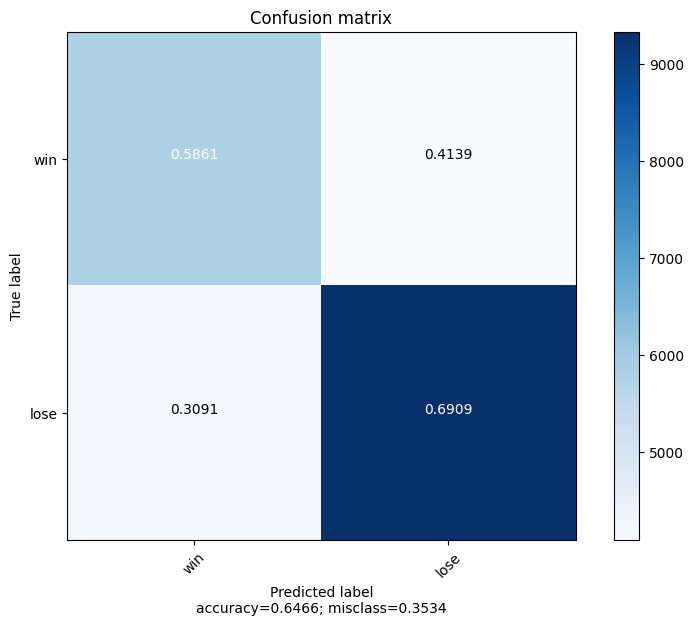

In [17]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["train/confusion_matrix"].upload(fig)


**OOF Classification report**

In [18]:
run["train/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

           0       0.58      0.59      0.58      9877
           1       0.70      0.69      0.69     13515

    accuracy                           0.65     23392
   macro avg       0.64      0.64      0.64     23392
weighted avg       0.65      0.65      0.65     23392



**Train Feature Importance via Weight/Splits - the number of times a feature appears in a tree**

<AxesSubplot: title={'center': 'Top 25 Feature importance - weight'}, xlabel='F score', ylabel='Features'>

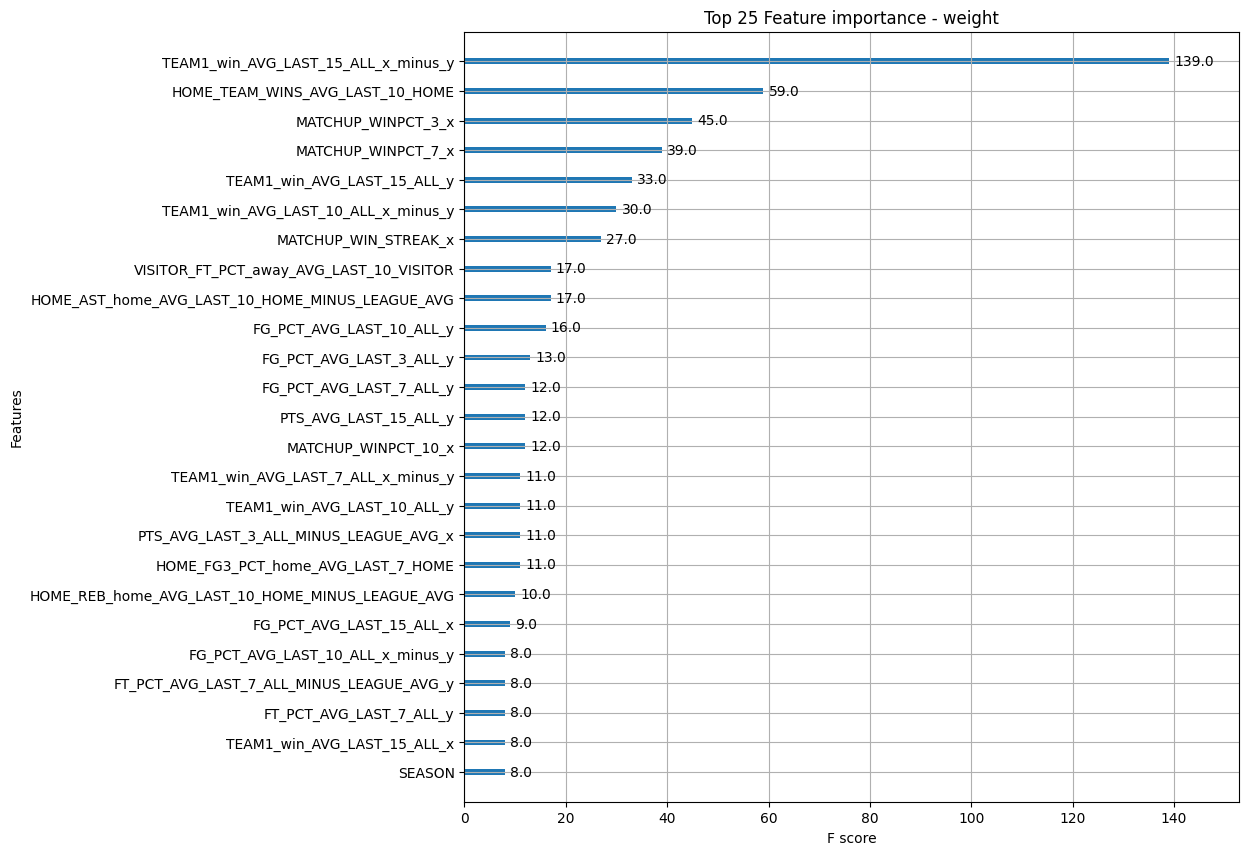

In [19]:
if MODEL_NAME == "xgboost":
    IMPORTANCE_TYPE = 'weight'
if MODEL_NAME == "lightgbm":
    IMPORTANCE_TYPE = 'split'

max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - ' + IMPORTANCE_TYPE
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type=IMPORTANCE_TYPE, max_num_features=max_features, title=max_title ,ax=ax)
#run["train/feature_importance_" + IMPORTANCE_TYPE].upload(fig)

**Train Feature Importance via Gain - the average gain of splits which use the feature**

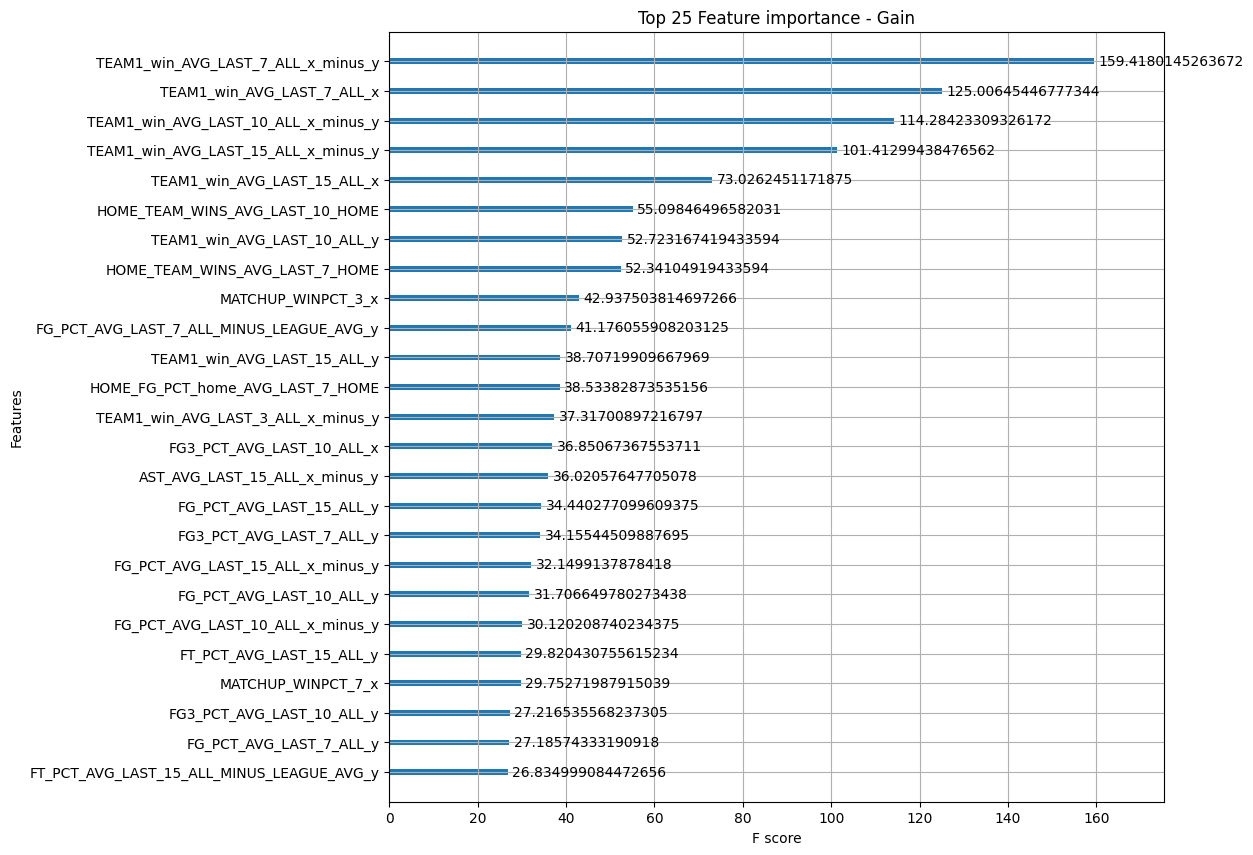

In [20]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type='gain', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_gain"].upload(fig)

**OOF Feature Importance via Shapley values**

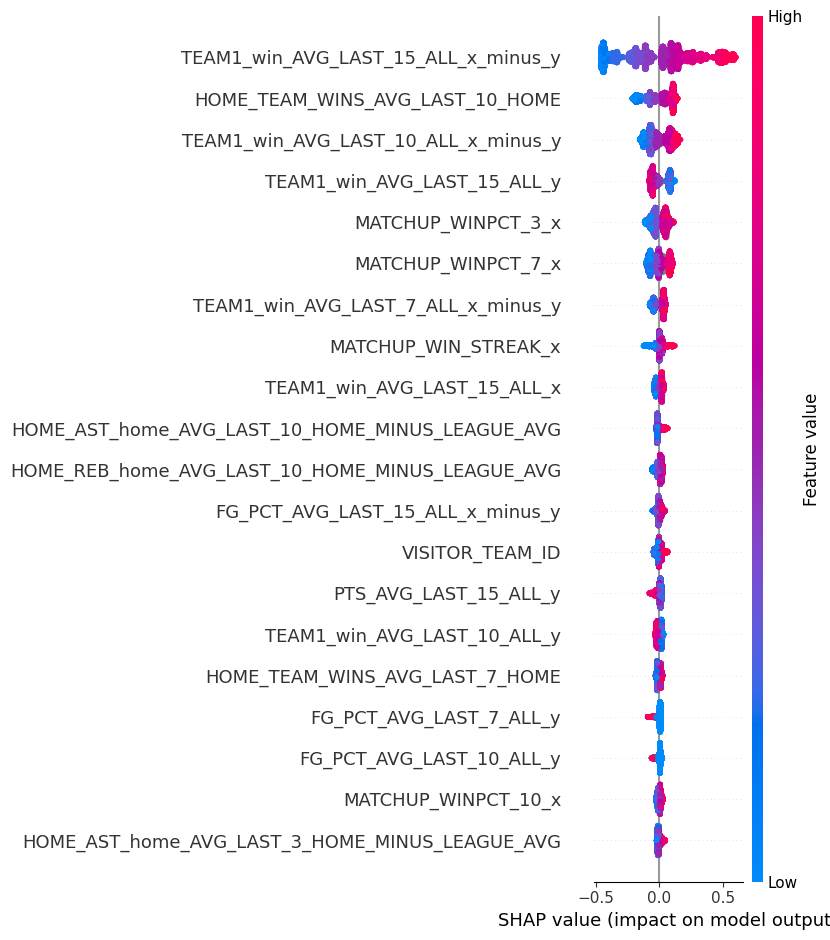

In [21]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["train/shapley_summary"].upload(fig)

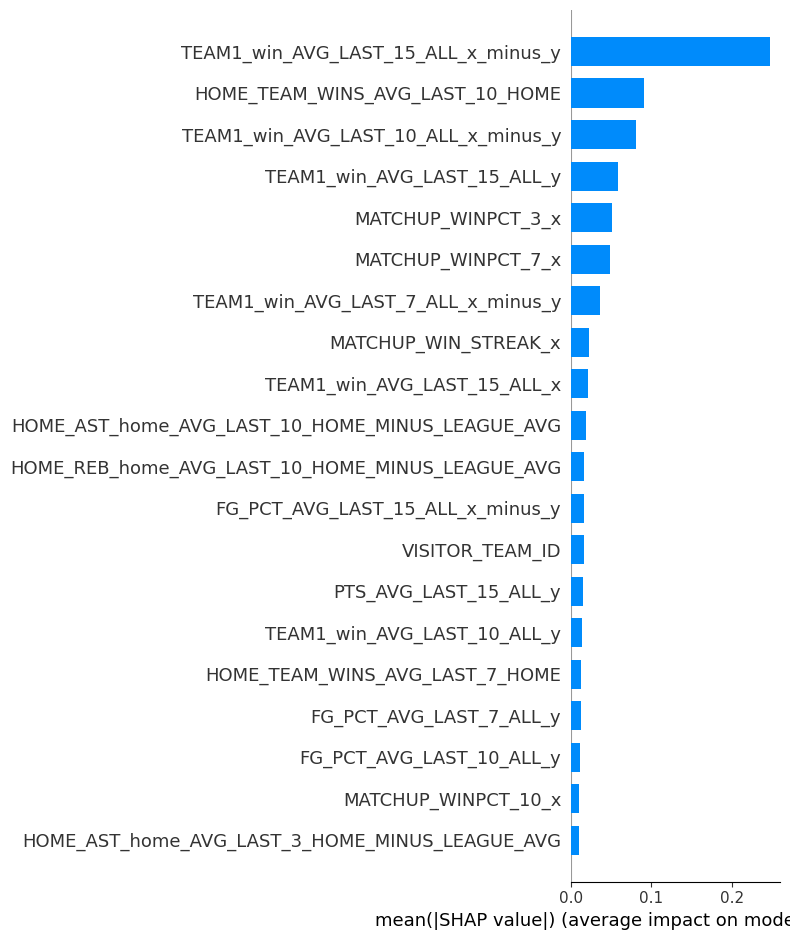

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["train/shapley_summary_bar"].upload(fig)

**Save train data with predictions**


In [23]:
train['TARGET'] = target
train['PredictionPct'] = train_oof
train['Prediction'] = train_oof_binary
train.to_csv(DATAPATH / "train_predictions.csv",index=False)

### Test Data Evaluation

In [24]:
if MODEL_NAME == "xgboost":
    test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
if MODEL_NAME == "lightgbm":
    test_data = test

test_preds = model.predict(test_data)
test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

run["test/accuracy"] = acc_score 
run["test/AUC"] = auc_score 
run["test/optimal_threshold"] = optimal_threshold

df = {'Label': 'Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)   




Scores:

Accuracy Score: 0.6289752650176679
AUC Score: 0.6297397007583522
Optimal Threshold: 0.49177653


**Test Confusion Matrix**

[[124  40]
 [ 65  54]]


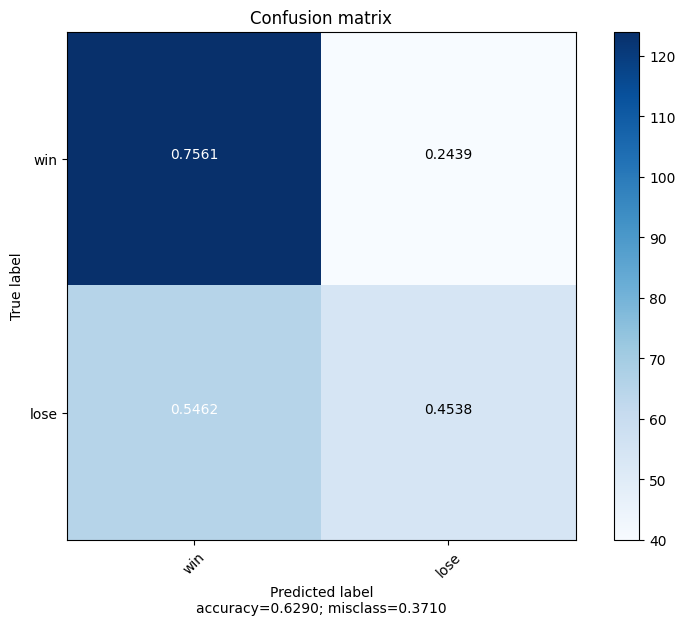

In [25]:
cm = confusion_matrix(test_target, test_preds_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["test/confusion_matrix"].upload(fig)


**Test Classification report**

In [26]:
run["test/classification_report"] = classification_report(test_target, test_preds_binary)
print(classification_report(test_target, test_preds_binary))

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       164
           1       0.57      0.45      0.51       119

    accuracy                           0.63       283
   macro avg       0.62      0.60      0.60       283
weighted avg       0.62      0.63      0.62       283



**Test Feature Importance via Shapley values**

For comparison to cross-validation OOF Shapley values to ensure that the model is working in similar manner on the test data as train data

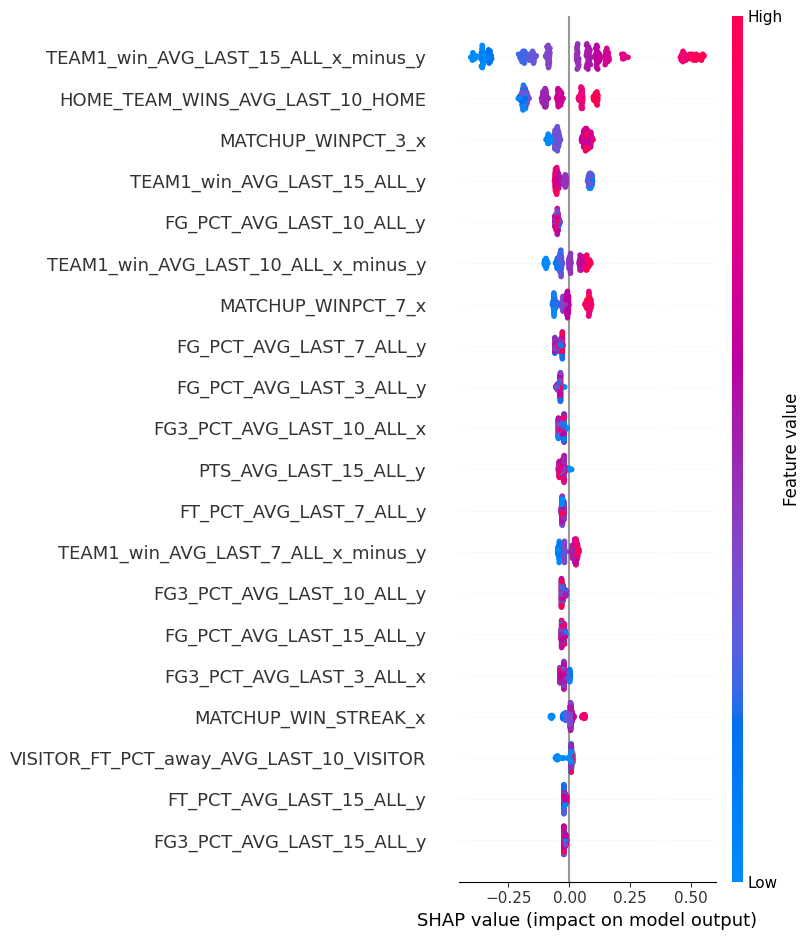

In [27]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test)
run["test/shapley_summary"].upload(fig)

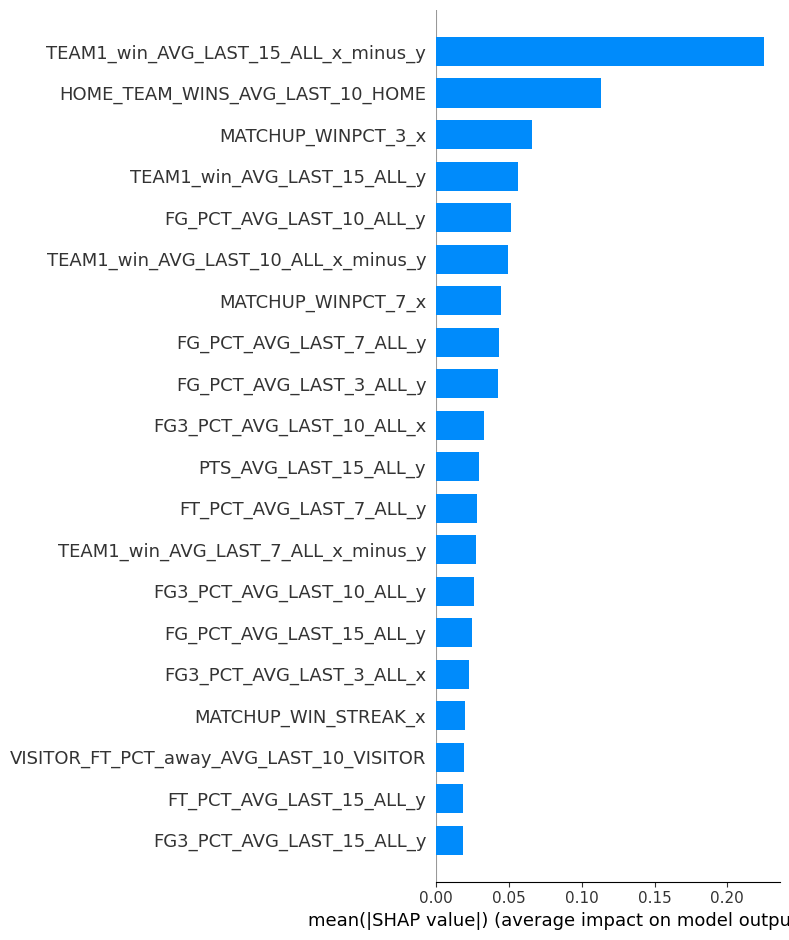

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test[use_columns], plot_type="bar")
run["test/shapley_summary_bar"].upload(fig)

**Save test data with predictions**


In [29]:
test['TARGET'] = test_target
test['PredictionPct'] = test_preds
test['Prediction'] = test_preds_binary
test.to_csv(DATAPATH / "test_predictions.csv",index=False)

## Model Evaluation

 - Compare Simple model predictions vs ML Test data predictions
 - Compare OOF/Train data vs Test/Validation data
 - Compare early season Test data vs later season Test data
 
 Feature importances via Shapley values are *local* to the given dataset and can assist in adversarial validation

**Split Test data**

Compare the model performance on the early part of the test data vs the later part of the test data

In [30]:
test = pd.read_csv(DATAPATH / TEST_NAME)
test = fix_datatypes(test, date_fields, long_integer_fields)
test = encode_categoricals(test, category_columns, MODEL_NAME, ENABLE_CATEGORICAL)

num_of_rows = test.shape[0] 
test = test.sort_values(by=['GAME_DATE_EST']) # sort the data by date
SPLIT = test.iloc[num_of_rows//2]['GAME_DATE_EST'] # split the data in half and find the date in the middle
 

run["test_split_Test1/end_date"] = SPLIT
run["test_split_Test2/start_date"] = SPLIT

test1 = test[test['GAME_DATE_EST'] < SPLIT]
test2 = test[test['GAME_DATE_EST'] >= SPLIT]

test1_target = test1['TARGET']
test2_target = test2['TARGET']


test1 = test1[use_columns]
test2 = test2[use_columns]

test1


,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,MONTH,HOME_TEAM_WIN_STREAK,HOME_TEAM_WINS_AVG_LAST_3_HOME,HOME_TEAM_WINS_AVG_LAST_7_HOME,HOME_TEAM_WINS_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME,HOME_PTS_home_AVG_LAST_7_HOME,HOME_PTS_home_AVG_LAST_10_HOME,HOME_FG_PCT_home_AVG_LAST_3_HOME,HOME_FG_PCT_home_AVG_LAST_7_HOME,HOME_FG_PCT_home_AVG_LAST_10_HOME,HOME_FT_PCT_home_AVG_LAST_3_HOME,HOME_FT_PCT_home_AVG_LAST_7_HOME,HOME_FT_PCT_home_AVG_LAST_10_HOME,HOME_FG3_PCT_home_AVG_LAST_3_HOME,HOME_FG3_PCT_home_AVG_LAST_7_HOME,HOME_FG3_PCT_home_AVG_LAST_10_HOME,HOME_AST_home_AVG_LAST_3_HOME,HOME_AST_home_AVG_LAST_7_HOME,HOME_AST_home_AVG_LAST_10_HOME,HOME_REB_home_AVG_LAST_3_HOME,HOME_REB_home_AVG_LAST_7_HOME,HOME_REB_home_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,VISITOR_TEAM_WIN_STREAK,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR,VISITOR_PTS_away_AVG_LAST_3_VISITOR,VISITOR_PTS_away_AVG_LAST_7_VISITOR,VISITOR_PTS_away_AVG_LAST_10_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR,VISITOR_AST_away_AVG_LAST_3_VISITOR,VISITOR_AST_away_AVG_LAST_7_VISITOR,VISITOR_AST_away_AVG_LAST_10_VISITOR,VISITOR_REB_away_AVG_LAST_3_VISITOR,VISITOR_REB_away_AVG_LAST_7_VISITOR,VISITOR_REB_away_AVG_LAST_10_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,MATCHUP_WINPCT_3_x,MATCHUP_WINPCT_7_x,MATCHUP_WINPCT_10_x,MATCHUP_WIN_STREAK_x,WIN_STREAK_x,HOME_AWAY_STREAK_x,TEAM1_win_AVG_LAST_3_ALL_x,TEAM1_win_AVG_LAST_7_ALL_x,TEAM1_win_AVG_LAST_10_ALL_x,TEAM1_win_AVG_LAST_15_ALL_x,PTS_AVG_LAST_3_ALL_x,PTS_AVG_LAST_7_ALL_x,PTS_AVG_LAST_10_ALL_x,PTS_AVG_LAST_15_ALL_x,FG_PCT_AVG_LAST_3_ALL_x,FG_PCT_AVG_LAST_7_ALL_x,FG_PCT_AVG_LAST_10_ALL_x,FG_PCT_AVG_LAST_15_ALL_x,FT_PCT

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 78 to 49
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int32(1), int8(21)
memory usage: 134.0 KB


**Process Splits**

TEST1

Scores:

Accuracy Score: 0.6159420289855072
AUC Score: 0.6048677248677248
Optimal Threshold: 0.49177653
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        75
           1       0.60      0.48      0.53        63

    accuracy                           0.62       138
   macro avg       0.61      0.60      0.60       138
weighted avg       0.61      0.62      0.61       138



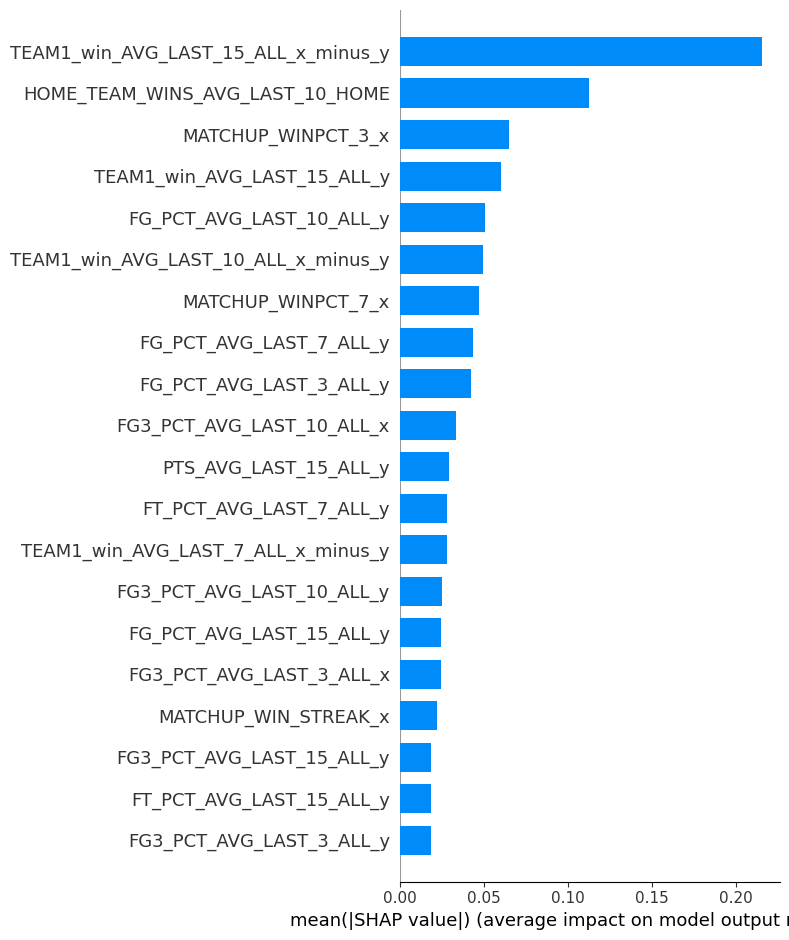

TEST2

Scores:

Accuracy Score: 0.5586206896551724
AUC Score: 0.6544943820224719
Optimal Threshold: 0.36351436
              precision    recall  f1-score   support

           0       0.86      0.34      0.48        89
           1       0.46      0.91      0.61        56

    accuracy                           0.56       145
   macro avg       0.66      0.62      0.55       145
weighted avg       0.71      0.56      0.53       145



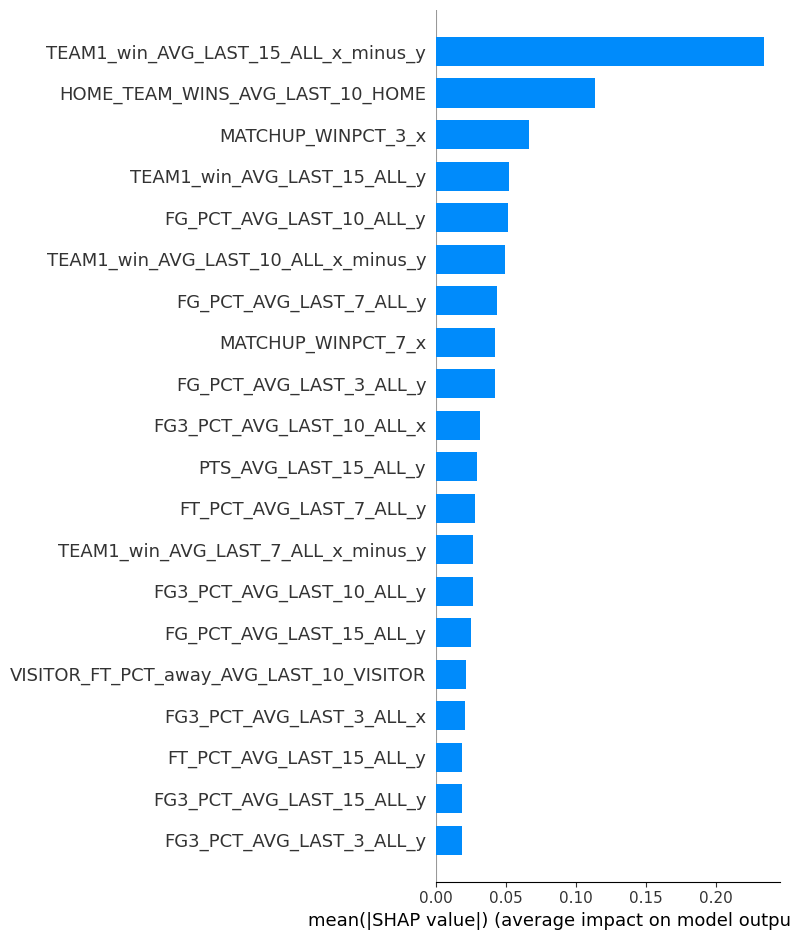

In [32]:
def process_splits(label, test, test_target, results):

    if MODEL_NAME == "xgboost":
        test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
    if MODEL_NAME == "lightgbm":
        test_data = test

    test_preds = model.predict(test_data)
    test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

    test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

    run["test_split_" + label + "/accuracy"] = acc_score 
    run["test_split_" + label + "/AUC"] = auc_score 
    run["test_split_" + label + "/optimal_threshold"] = optimal_threshold

    df = {'Label': label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
    results = results.append(df, ignore_index = True) 

    run["test_split_" + label + "/classification_report"] = classification_report(test_target, test_preds_binary)
    print(classification_report(test_target, test_preds_binary))
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    shap.summary_plot(test_preds_shap[:,:-1], test, plot_type="bar")
    #run["test_split_" + label + "/shapley_summary_bar"].upload(fig)

    #Simple model applied to split
    acc_score, auc_score = SimpleModel(test, test_target)
    df = {'Label': 'Simple-' + label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
    results = results.append(df, ignore_index = True) 
    
    return test_preds_shap, results
    
print("TEST1")
test_preds_shap1, results = process_splits('Test1',test1, test1_target, results)
print("TEST2")
test_preds_shap2, results = process_splits('Test2',test2, test2_target, results)


**Summary Table**

Key metrics from Simple Model, Train, Test, and Test-split

In [33]:
acc_score1  = results.loc[results['Label'] == 'Train', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Train', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Train-Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/train-test_accuracy"] = acc_score
run["evaluation/train-test_AUC"] = auc_score

acc_score1  = results.loc[results['Label'] == 'Test1', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test2', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Test1', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test2', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Test1-Test2', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/test1-test2_accuracy"] = acc_score
run["evaluation/test1-test2_AUC"] = auc_score

run["evaluation/summary_table"].upload(File.as_html(results))
results

,Label,Accuracy,AUC,Threshold
0,Simple Model,0.420495,0.500000,N/A
1,Train,0.646631,0.691481,0.549757
2,Test,0.628975,0.629740,0.491777
3,Test1,0.615942,0.604868,0.491777
4,Simple-Test1,0.456522,0.500000,N/A
5,Test2,0.558621,0.654494,0.363514
6,Simple-Test2,0.386207,0.500000,N/A
7,Train-Test,0.017656,0.061741,N/A
8,Test1-Test2,0.057321,-0.049627,N/A


**Train vs Test Feature Importances via Shapley Values**

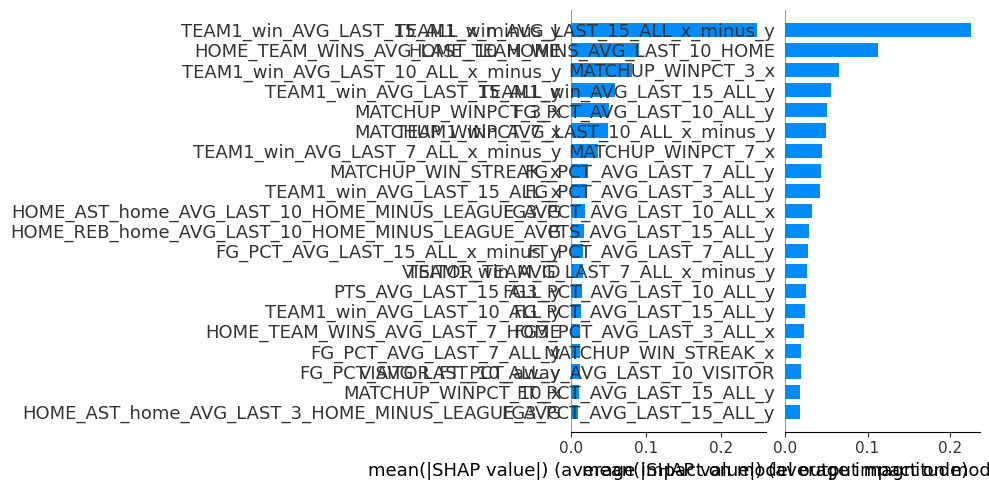

In [34]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
#run["evaluation/test_train_shapley_summary_bar"].upload(fig)

**Test1 vs Test2 Feature Importances via Shapley Values**

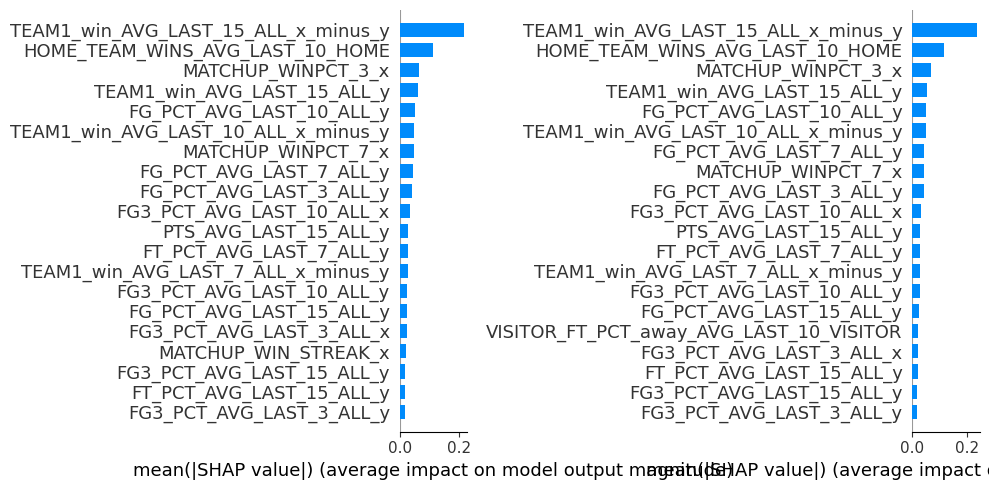

In [35]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(test_preds_shap1[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap2[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
#run["evaluation/test1_test2_shapley_summary_bar"].upload(fig)

**End experiment tracking**

In [36]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 85 operations to synchronize with Neptune. Do not kill this process.
All 85 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-145


**Save Tuned Hyperparameters**

Optional function - when run, it overwrites the current "best" hyperparameters with the newly generated hyperparameters. Some descretion is required.

In [37]:
def save_tuned_params(MODEL_NAME, tuned_params):
    with open(MODEL_NAME + '.json', 'w') as f:
        f.write(json.dumps(tuned_params))
        
save_tuned_params(MODEL_NAME, tuned_params)

**Visualize Data Comparisons**

In [38]:
# run Sweetviz comparing test data that led to a correct prediction vs incorrect prediction

test = pd.read_csv(DATAPATH / 'test_predictions.csv')

test['TARGET'] = test['TARGET'].astype('int8')
test['Prediction'] = test['Prediction'].astype('int8')

test_correct = test[test['TARGET'] == test['Prediction']]
test_wrong = test[test['TARGET'] != test['Prediction']]

#run_sweetviz_comparison(test_correct, 'Test-Correct', test_wrong, 'Test-Wrong', 'Prediction', 'correct-incorrect')

**Calibrate Probabilities**

The goal of the prediction model is to predict the probability of a win or loss for each game. We need to make sure that the model is predicting probabilities that are in line with the actual win/loss outcomes. The proba predictions from most classifiers do not typically align with the actual outcomes. Calibration fits a function to the model's probabilities and the actual outcomes.

The first step is to plot the actual probability distribution of the base model against a perfectly calibrated ideal distribution. In some cases, the base model may be sufficient on its own, but it can often be improved by calibrating the probabilities.

Next, we apply SKLearns built-in functions to calibrate the model's probabilities. This is done by fitting both an isotonic regression model and a sigmoid regression model to the model's probabilities and the actual outcomes. These fitted curves represent calibrated probabilities.

By plotting the graph, we can see how well the model's probabilities are calibrated. The ideal distribution is represented by the dotted line, and the model "closest" to this line is the best calibrated model.

Brier loss is typically used to numerically measure how well the model is calibrated. It is a measure of the mean squared difference between the predicted probabilities and the actual outcomes. The lower the Brier loss, the better the calibration.

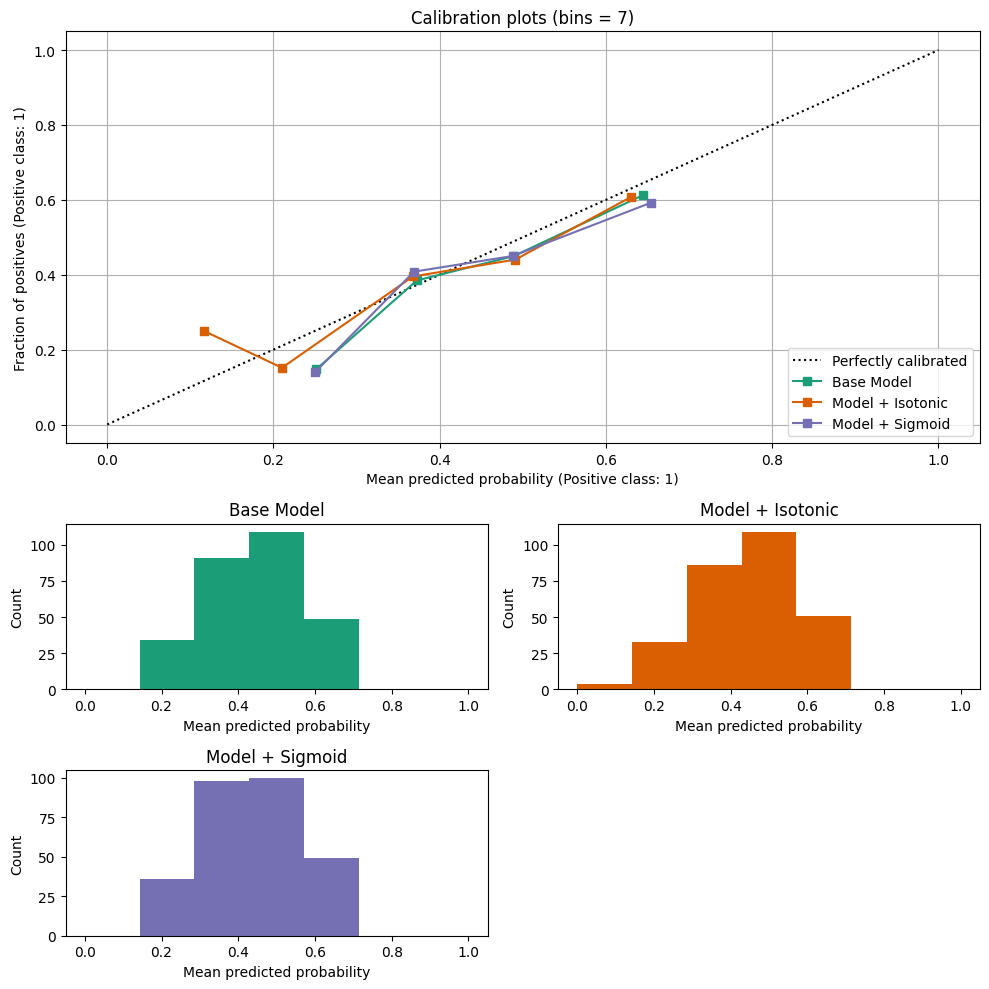

In [39]:
# since we are using SKLearn's built in functions to to calibrate and plot the probability curves, 
# we first need to convert our model to one using a SKLearn wrapper.
if MODEL_NAME == "xgboost":
    model = XGBClassifier(n_estimators=NUM_BOOST_ROUND, **model_params)
if MODEL_NAME == "lightgbm":
    model = LGBMClassifier(verbose_eval=False, **model_params)

# we then set up CalibratedClassifierCV using Isotonic and Sigmoid Regression
model_isotonic = CalibratedClassifierCV(model, cv=5, method="isotonic")
model_sigmoid = CalibratedClassifierCV(model, cv=5, method="sigmoid")

clf_list = [
    (model, "Base Model"),
    (model_isotonic, "Model + Isotonic"),
    (model_sigmoid, "Model + Sigmoid"),
]

y_train = target
y_test = test_target_original

X_train = train[use_columns]
X_test = test_original

plot_calibration_curve(clf_list, X_train, y_train, X_test, y_test, n_bins=7)

In [40]:
# calculate classification metrics we will use to compare the models
# and return an updated clf_list that includes the trained/fitted models
df_scores, clf_list = calculate_classification_metrics(clf_list, X_train, y_train, X_test, y_test)
df_scores = df_scores.reset_index()
df_scores

,Classifier,Brier loss,Log loss,Precision,Recall,F1,Roc auc
0,Base Model,0.232167,0.656008,0.543478,0.420168,0.473934,0.582035
1,Model + Isotonic,0.231816,0.655417,0.542553,0.428571,0.478873,0.583188
2,Model + Sigmoid,0.232180,0.656083,0.547619,0.386555,0.453202,0.577424


**Select Best Model Calibration and Save**

Select the model with the lowest Brier loss score and save the calibrated model to a pickle file. This is the model that will be used for the final predictions.

In [41]:
df_best = df_scores.loc[df_scores['Brier  loss'].idxmin()]
best_calibrated_model = df_best['Classifier']

print("Best calibrated model is: ", best_calibrated_model)


Best calibrated model is:  Model + Isotonic


In [42]:
# save the pickeled model and key metrics so that it can be saved to the model registry later on


#retrieve the AUC and Accuracy scores for the test set from the summary table we created earlier named 'results'
test_results = results.loc[results['Label'] == 'Test'] 
auc_score = test_results['AUC'].values[0]
acc_score = test_results['Accuracy'].values[0]

#select the best calibrated model from the list of models we created earlier
model = [classifier for (classifier, name) in clf_list if name == best_calibrated_model][0]


joblib.dump(model, 'model.pkl')

model_data = {
            'model_name': MODEL_NAME,
            'calibration_method': best_calibrated_model,
            'brier_loss': df_best['Brier  loss'],
            'metrics':{'AUC': auc_score, 'Accuracy': acc_score },
            }
    
with open('model_data.json', 'w') as f:
    f.write(json.dumps(model_data))

## Notes



The output for each run is saved at Neptune.ai at the following link: https://app.neptune.ai/cmunch1/nba-prediction/experiments?split=tbl&dash=charts&viewId=979e20ed-e172-4c33-8aae-0b1aa1af3602



